In [1]:
# code aangepast van https://www.philschmid.de/bert-text-classification-in-a-different-language

In [1]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from datasets.dataset_dict import DatasetDict
from datasets import Dataset
import torch
import pyarrow
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModel, TFAutoModel
from simpletransformers.classification import ClassificationModel
import warnings
warnings.filterwarnings('ignore')

In [2]:
# check device waarop de code runt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [4]:
# gebruik pretrained model (cased!): https://huggingface.co/GroNLP/bert-base-dutch-cased
tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
model = AutoModel.from_pretrained("GroNLP/bert-base-dutch-cased")  # PyTorch

Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stre

In [5]:
# inladen data
dataset_path = "~/share/Milena/programma-discriminatie-en-racisme/datasets/"
dataset_zoek = pd.read_csv(dataset_path + 'dataset_dummy.csv', sep = ',')

In [6]:
# bekijken dataset
print(dataset_zoek.columns)

display(dataset_zoek)

Index(['Unnamed: 0', 'document', 'text', 'zin', 'label', 'score_annotator',
       'totaalscore'],
      dtype='object')


,Unnamed: 0,document,text,zin,label,score_annotator,totaalscore
0,0,Beslisnota bij Kamerbrief over Geografische Ba...,...,...,positief,0.449565,0
1,1,Beslisnota bij Kamerbrief over Geografische Ba...,...,b,positief,0.125925,0
2,2,Beslisnota bij Kamerbrief over Geografische Ba...,...,t,positief,0.855116,1
3,3,Beslisnota bij Kamerbrief over Geografische Ba...,...,de\n Subsidieregelin...,positief,0.909220,1
4,4,Beslisnota bij Kamerbrief over Geografische Ba...,...,l,positief,0.238765,0
...,...,...,...,...,...,...,...
7177,7177,Agenda Natuurinclusief 2.0,"We realiseren het ons niet dagelijks, maar nat...",\n VISUALISATIE COLLECTIEF NATUURINCLUSIE...,positief,0.223324,0
7178,7178,Agenda Natuurinclusief 2.0,"We realiseren het ons niet dagelijks, maar nat...",Wij zorgen voor een ‘vruchtbare bodem’ met co...,positief,0.317717,0
7179,7179,Agenda Natuurinclusief 2.0,"We realiseren het ons niet dagelijks, maar nat...",Dit doen we met ie-\n dereen samen,positief,0.761689,1
7180,7180,Agenda Natuurinclusief 2.0,"We realiseren het ons niet dagelijks, maar nat...",Zie de visualisatie van de beweging natuurinc...,positief,0.146005,0


In [52]:
# prepareer dataset voor inladen in model
dataset = dataset_zoek.drop(columns = ['Unnamed: 0', 'document', 'zin', 'label', 'score_annotator'])
dataset = dataset.rename(columns={"totaalscore": "label", 'text': 'text'}) # totaalscore/label = doel, text = ingelezen tekst

# split dataset: 60% train, 20% val, 20% test
train_val_df, test_df = train_test_split(dataset, test_size=0.20)
train_df, val_df = train_test_split(train_val_df, test_size=0.25)

print(len(train_df), len(val_df), len(test_df))

4308 1437 1437


In [53]:
# define hyperparameters
# to change parameters: zie https://simpletransformers.ai/docs/usage/#configuring-a-simple-transformers-model
train_args ={"reprocess_input_data": True, # tokenization gebeurt binnen model
             "fp16":False,
             "overwrite_output_dir": True,
             "num_train_epochs": 10, # hoeveel epochs
             "evaluate_during_training": True, # om validation data in te laten
            "evaluation_strategy":"steps", # slaat een tussentijds model op om te evalueren
            "eval_steps": 2000, # hoe vaak het model wordt opgeslagen
            "train_batch_size": 8, # batch size trainingsdata
            "eval_batch_size": 8} # batch size validation data

# Create a ClassificationModel (code uit bron; zie bovenaan notebook)
model = ClassificationModel(
    "bert", "GroNLP/bert-base-dutch-cased",
    num_labels=2, # hoeveel mogelijke targets er zijn
    args=train_args,
    use_cuda=False # omdat dit op de cpu draait
)

Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.weight

In [54]:
# trainen!
train_results = model.train_model(train_df = train_df, eval_df = val_df)

  0%|          | 0/4308 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/1437 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/1437 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/1437 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/1437 [00:00<?, ?it/s]

  0%|          | 0/1437 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/1437 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/1437 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/1437 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/1437 [00:00<?, ?it/s]

  0%|          | 0/1437 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/1437 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/1437 [00:00<?, ?it/s]

In [55]:
# testen
from sklearn.metrics import f1_score, accuracy_score

# om f1 te kunnen genereren
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

result, model_outputs, wrong_predictions = model.eval_model(test_df, f1=f1_multiclass, acc=accuracy_score)


  0%|          | 0/1437 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/180 [00:00<?, ?it/s]

In [56]:
# resultaten: mcc = , tp = true positives, tn = true negatives, fp = false negatives, fn = false negatives
print(result)

{'mcc': 0.010564139633674492, 'tp': 152, 'tn': 564, 'fp': 140, 'fn': 581, 'auroc': 0.5190395169291827, 'auprc': 0.52162623481858, 'f1': 0.49826026443980515, 'acc': 0.49826026443980515, 'eval_loss': 0.7044144514534209}


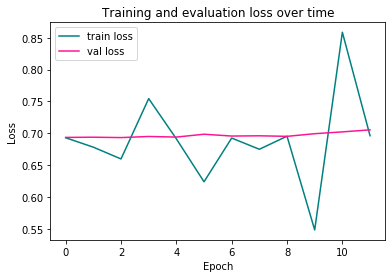

In [57]:
# maak een plotje van de loss
train_losses = train_results[1]['train_loss']
eval_losses = train_results[1]['eval_loss']

plt.plot(train_losses, c = 'teal', label = 'train loss')
plt.plot(eval_losses, c = 'deeppink', label = 'val loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and evaluation loss over time')
plt.show()

In [49]:
print(train_results)

(2156, defaultdict(<class 'list'>, {'global_step': [539, 1078, 1617, 2000, 2156], 'train_loss': [0.7379406690597534, 0.6330585479736328, 0.6847595572471619, 0.7972209453582764, 0.7139491438865662], 'mcc': [0.0, 0.0, 0.0, 0.0, 0.0], 'tp': [0, 0, 718, 718, 718], 'tn': [719, 719, 0, 0, 0], 'fp': [0, 0, 719, 719, 719], 'fn': [718, 718, 0, 0, 0], 'auroc': [0.5083323325107217, 0.5226918770654073, 0.5231480584687026, 0.5216710380015575, 0.5078519376571452], 'auprc': [0.5118670122931934, 0.5202298188071524, 0.5192006181956035, 0.5189424266537208, 0.514318325013898], 'eval_loss': [0.6938578890429603, 0.7149107552236981, 0.7080961217482885, 0.7001600937710868, 0.6939940949281057]}))


In [60]:
model.evaluate(eval_df = val_df, output_dir = output_dir)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'output_dir' is not defined

In [ ]:
# OUDE/ANDERE CODE

In [ ]:
#dataset = dataset_zoek.drop(columns = ['Unnamed: 0', 'document', 'zin', 'label', 'score_annotator'])
#dataset = dataset.rename(columns={"totaalscore": "label", 'text': 'text'})
print(dataset.columns)


X = list(dataset_zoek["text"])
y = list(dataset_zoek["totaalscore"])
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.25)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

In [ ]:
#tokenized_train = tokenizer(dataset['train']["text"], return_tensors="np", padding=True)
# Tokenizer returns a BatchEncoding, but we convert that to a dict for Keras
#tokenized_data = dict(tokenized_train)
                     
#labels_train = np.array(dataset['train']["label"])  # Label is already an array of 0 and 1)

In [ ]:
# trainen
# sla training_arguments op
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
    reprocess_input_data= True,
    fp16=False,
    overwrite_output_dir = True
)

metric = evaluate.load("accuracy")

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [ ]:
# train model!
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train,
    eval_dataset=val,
    compute_metrics=compute_metrics,
)

trainer.train()

In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

In [ ]:
# maak dataset correcte format: [{'label': value, 'text': text}, {'label': value, 'text': text}]
data = []

for i in range(len(dataset_zoek)):
    label = dataset_zoek['totaalscore'].iloc[i]
    text = dataset_zoek['zin'].iloc[i]
    tokenized_text = tokenizer(str(text), return_tensors="np", padding=True)
    duo = {'label': label, 'text': tokenized_text}
    data.append(duo)
    
print(len(data))

In [ ]:
# split dataset: 60% train, 20% val, 20% test
trainval, test = train_test_split(data, train_size = 0.8)
train, val = train_test_split(trainval, train_size = 0.75)

print(len(train), len(val), len(test))

In [ ]:
train_labels = []

for item in train:
    train_labels.append(item['label'])

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback

# Read data
dataset_zoek = pd.read_csv(dataset_path + 'dataset_dummy.csv', sep = ',') # model is te groot om te trainen met volledige dataset zonder GPU
dataset = dataset_zoek.drop(columns = ['Unnamed: 0', 'document', 'zin', 'label', 'score_annotator'])
dataset = dataset.rename(columns={"totaalscore": "label", 'text': 'text'})

# Define pretrained tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
model = AutoModel.from_pretrained("GroNLP/bert-base-dutch-cased")  # PyTorch

# ----- 1. Preprocess data -----#
# Preprocess data
X = list(dataset_zoek["text"])
y = list(dataset_zoek["totaalscore"])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)



In [ ]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

# ----- 2. Fine-tune pretrained model -----#
# Define Trainer parameters
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}



In [ ]:
# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

# Train pre-trained model
trainer.train()

In [ ]:
# ----- 3. Predict -----#
# Load test data
test_data = pd.read_csv("test.csv")
X_test = list(test_data["review"])
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
test_dataset = Dataset(X_test_tokenized)

# Load trained model
model_path = "output/checkpoint-50000"
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

In [ ]:
ds = Dataset.from_pandas(dataset)

print(ds)

# split dataset: 60% train, 20% val, 20% test
train_testvalid = ds.train_test_split(test_size=0.4)
# Split the 40% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
ds = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

print(ds['train']['text'][100])

In [ ]:
def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=True,
        return_dict=True,
        tokenizer=None, 
        topic=None, 
        freeze_bert = None, 
        num_feats=None, 
        keep_stopwords = None,
        combined_feats = None, 
        sum_layers = None
    ):
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

       
        combined_feats=aggregate_features(outputs, tokenizer, input_ids, topic, 
                                     num_feats, keep_stopwords, sum_layers).to(device)
        combined_feats = self.dropout(combined_feats)
        logits = self.classifier(combined_feats)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )